In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from einops import rearrange
from tqdm import tqdm
from shapely import box
from geocube.api.core import make_geocube


import cv2

root = Path.cwd()

In [2]:
epsg = 26919
site_name = 'BART'
year = '2019'

b = xr.open_dataarray(root / 'sentinel_data' / f'{year}_{site_name}.nc')
b = b.rio.write_crs(epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

In [2]:
class DataStack():
    """Class containing processed data for input into minimum noise fraction functions"""
    def __init__(self,root,year,site_name,epsg):
        self.root = root
        self.year = year
        self.site_name = site_name
        self.epsg = int(epsg)

        b = xr.open_dataarray(self.root / 'sentinel_data' / f'{self.year}_{self.site_name}.nc')
        self.input_data = b.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()

        self.season_data = None
        self.aligned_data = None    

        f = self.root / 'sentinel_data' / f'{self.year}_{self.site_name}_variables.nc'
        if os.path.isfile(f):
            self.all_variables = xr.open_dataarray(f)
        else:
            self.all_variables = None
        
        ff = self.root / 'sentinel_data' / f'{self.year}_{self.site_name}_pca.nc'
        if os.path.isfile(ff):
            self.pca = xr.open_dataarray(ff)
        else:
            self.pca = None
    
    
    def plot_input_data(self):
        self.input_data.isel(band=4).plot(col='time',col_wrap=4)

    def plot_season_data(self):
        if self.season_data is not None:
            self.season_data.isel(band=4).plot(col='time',col_wrap=4)
        else:
            print('need to run method: select_season_data()')
    
    def plot_aligned_data(self):
        if self.aligned_data is not None:
            self.aligned_data.isel(band=4).plot(col='time',col_wrap=4)
        else:
            print('need to run method: coregister_data()')
    
    def select_season_data(self,date_list): # input date_list based on manual inspection of input data
        e = [str(x) for x in self.input_data.time.values if any(date in str(x) for date in date_list)]
        self.season_data =  self.input_data.sel(time=e)
    
    def get_gradient(self,im) :
        # Calculate the x and y gradients using Sobel operator
        grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
        grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
        # Combine the two gradients
        grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)

        return grad
    
    def coregister_data(self):
    
        # replace nas with 0
        b_sel = self.season_data.where(~np.isnan(self.season_data), other=0)
        # create reference image: mean of all temporal steps
        reference_image = self.season_data.mean(dim=['band','time'])
        # replace na with 0 
        reference_image = reference_image.where(~np.isnan(reference_image), other=0)

        # convert input data to numpy float32 numpy arrays
        reference_image = np.float32(reference_image.to_numpy())
        im = np.float32(b_sel.to_numpy())

        # define dimensions for output image
        height = b_sel.shape[2]
        width = b_sel.shape[3]
        time = b_sel.shape[0]
        band = b_sel.shape[1]

        ## Define motion model
        warp_mode = cv2.MOTION_AFFINE
        # Set the warp matrix to identity matrix
        warp_matrix = np.eye(2, 3, dtype=np.float32)
        # Set the stopping criteria for the algorithm.
        criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

        # Create empty array of correct size for new aligned images
        im_aligned = np.zeros((time,band,height,width), dtype=np.float32 )

        # loop over time and band dimensions and apply coregistration to each band
        for i in range(0,time):
            for j in tqdm(range(0,band)) :
                (_, warp_matrix) = cv2.findTransformECC(self.get_gradient(reference_image), self.get_gradient(im[i,j,:,:]),warp_matrix, warp_mode, criteria)    
                                                                       
                im_aligned[i,j,:,:] = cv2.warpAffine(im[i,j,:,:], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        b_align = xr.DataArray(im_aligned, 
                      coords={'time':b_sel.time,'band': b_sel.band,'y': b_sel.y,'x':b_sel.x}, 
                      dims=['time','band','y','x'])
        b_align = b_align.where(b_align!=0, other=np.nan) # reset 0 values to na
    

        self.aligned_data = b_align

    
    def remove_outliers(self,a,norm=True):
        a = a.where(np.isfinite(a),np.nan)
        if norm == True:
            a = a.where((a >= -1) & (a <= 1))
        else:
            a = a.where((a >= 0) & (a <= 8))
        return a
    
    def get_season_differences(self,array, band,season):
        d = array.sel(band=f'{band}_summer') - array.sel(band=f'{band}_{season}')
        return d.expand_dims({'band':[f'{band}_{season}_diff']})
    
    def add_all_variables(self):
        if self.aligned_data is None:
            print('need to run method: coregister_data()')
        else:
        # separate all bands onto 1 dimension
            array_list1 = list()
            for i, season in enumerate(['spring','summer','fall']):
                t = self.aligned_data.isel(time=i).reset_coords('time',drop=True)
                t = t.assign_coords({'band':[f'{x}_{season}' for x in self.aligned_data.band.values]})
                array_list1.append(t)

            m1 = xr.concat(array_list1,dim='band')

            # calculate evi, lswi, slavi, psri for each season
            season_list = ['spring','summer','fall']
            array_list2 = list()
            for i in range(0,3):
                blue = array_list1[i].sel(band=f'B02_{season_list[i]}')
                red = array_list1[i].sel(band=f'B04_{season_list[i]}')
                nir = array_list1[i].sel(band=f'B8A_{season_list[i]}')
                sw1 = array_list1[i].sel(band=f'B11_{season_list[i]}')
                sw2 = array_list1[i].sel(band=f'B12_{season_list[i]}')
                re2 = array_list1[i].sel(band=f'B06_{season_list[i]}')


                evi = 2.5 * ((nir - red) / (nir + 6 * red - 7.5 * blue + 1)).expand_dims({'band':[f'evi_{season_list[i]}']}) # range -1 - 1
                evi = self.remove_outliers(evi)

                lswi = (nir - sw1)/(nir + sw1).expand_dims({'band':[f'lswi_{season_list[i]}']}) # range -1 to 1
                lswi = self.remove_outliers(lswi)

                slavi = nir/(red + sw2).expand_dims({'band':[f'slavi_{season_list[i]}']}) # range 0 - 8
                slavi = self.remove_outliers(slavi,norm=False)

                psri = (red - blue)/re2.expand_dims({'band':[f'psri_{season_list[i]}']}) # range -1 to 1
                psri = self.remove_outliers(psri)

                season_vi = xr.concat([evi,lswi,slavi,psri],dim='band')

                array_list2.append(season_vi)

            m2 = xr.concat(array_list2,dim='band')

            # calculate differences for evi, lswi, slavi, and psri

            array_list3 = list()
            for vi in ['evi', 'lswi', 'slavi','psri']:
                for s in ['spring','fall']:
                    t = self.get_season_differences(m2,vi,s)
                    array_list3.append(t)

            m3 = xr.concat(array_list3,dim='band')

            m4 = xr.concat([m1,m2,m3],dim='band')

            ## mask non-forest pixels
            self.all_variables = m4.where(m4.sel(band='evi_summer')>0.5,other=np.nan)
            # save
            self.all_variables.to_netcdf(self.root / 'sentinel_data' / f'{self.year}_{self.site_name}_variables.nc')
            print(f'variables saved to {self.root}/sentinel_data/{self.year}_{self.site_name}_variables.nc')

    def run_pca(self):
        a = self.all_variables.values

        a_2d = rearrange(a, 'c h w -> (h w) c')
        # drop all na from data
        a2d_dropna = a_2d[~np.isnan(a_2d).any(axis=1)]
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(a_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        # rescale data around approximate mean of 0
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(a2d_dropna)

        n = 3
        pca = PCA(n_components=n)
        pca.fit(data_scaled)
        pca_data = pca.transform(data_scaled)
            
        # replace nans that were dropped earlier
        output_array = np.full((a_2d.shape[0],pca_data.shape[1]), np.nan)  # create array of correct shape

        # Fill in the rows that were not NaN
        non_nan_indices = np.setdiff1d(np.arange(a_2d.shape[0]), row_indices)  # get indices that don't have na values
        output_array[non_nan_indices] = pca_data

        # # reshape to original dimensions
        height = self.all_variables.shape[1]
        width = self.all_variables.shape[2]
        new_pca_data = rearrange(output_array, '(h w) c -> c h w', h=height, w=width)
        pca_array = xr.DataArray(new_pca_data, 
                            coords={'band': np.arange(0,n),'y': self.all_variables.y,'x': self.all_variables.x}, 
                            dims=['band','y','x'])
        # todo: return object with explained variance, plot function etc.
        self.pca = pca_array
        self.pca.to_netcdf(self.root / 'sentinel_data' / f'{self.year}_{self.site_name}_pca.nc')
        print(f'pca saved to {self.root}/sentinel_data/{self.year}_{self.site_name}_pca.nc')

    def plot_pca(self):
        fig = plt.subplots(figsize=(20,5))
        for i in range(0,3):
            plt.subplot(1, 3, i+1)
            self.pca.isel(pca_component=i).plot()
        plt.show()
           



In [3]:
roi = DataStack(root,2023,'roi',26918)

#roi.plot_input_data()

In [4]:
roi.select_season_data(date_list=['05-30','07-11','10-04'])
roi.plot_season_data()

In [6]:
roi.coregister_data()

100%|██████████| 10/10 [02:04<00:00, 12.42s/it]


In [7]:
roi.add_all_variables()

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/2023_roi_variables.nc


In [14]:
roi.run_pca()

variables saved to c:\Users\roseh\OneDrive - Hunter - CUNY\Documents\beech_tree/sentinel_data/2023_roi_pca.nc


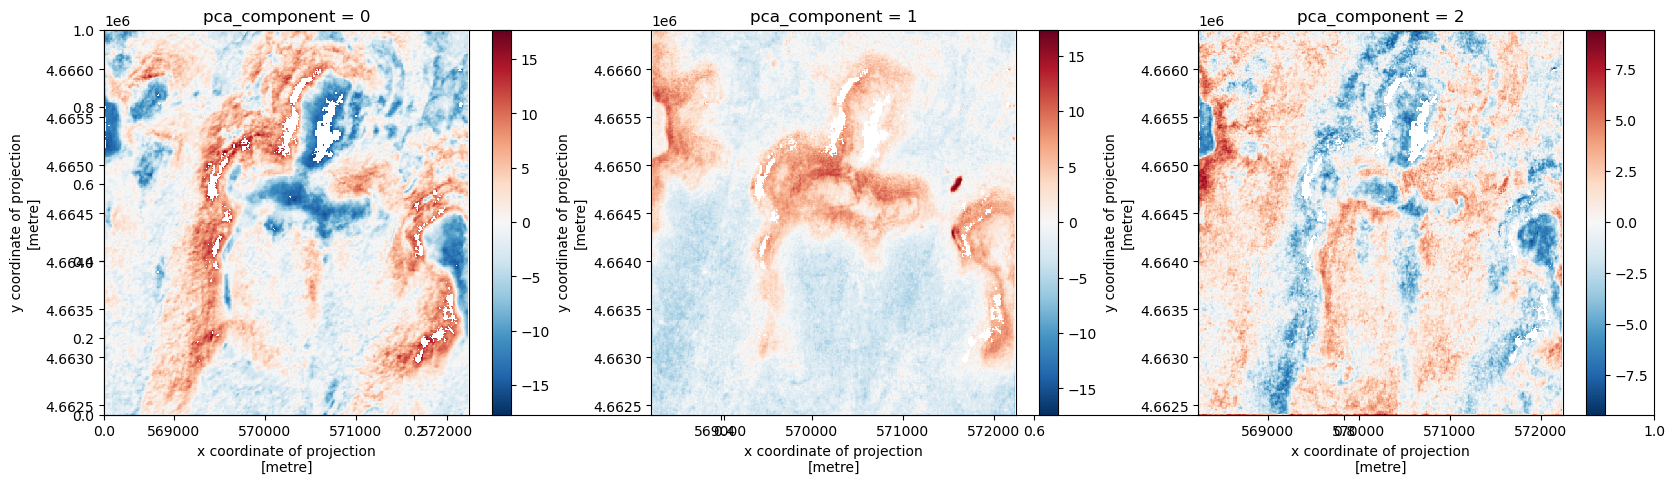

In [4]:
# check pca output
roi.plot_pca()

### Minimum Noise Fraction

In [3]:
stack = DataStack(root,2023,'roi',26918)
stack.pca = stack.pca.rename({'pca_component':'band'})

In [14]:
a = stack.all_variables.sel(band=[x for x in stack.all_variables.band.values if x.endswith('spring') & x.startswith('B')])
b = stack.all_variables.sel(band=[x for x  in stack.all_variables.band.values if 'diff' in x ]) 

s = xr.concat([stack.pca,a,b],dim='band')


In [43]:
w = MNF(s)

In [50]:
w.mnf.shape

(401, 401, 10)

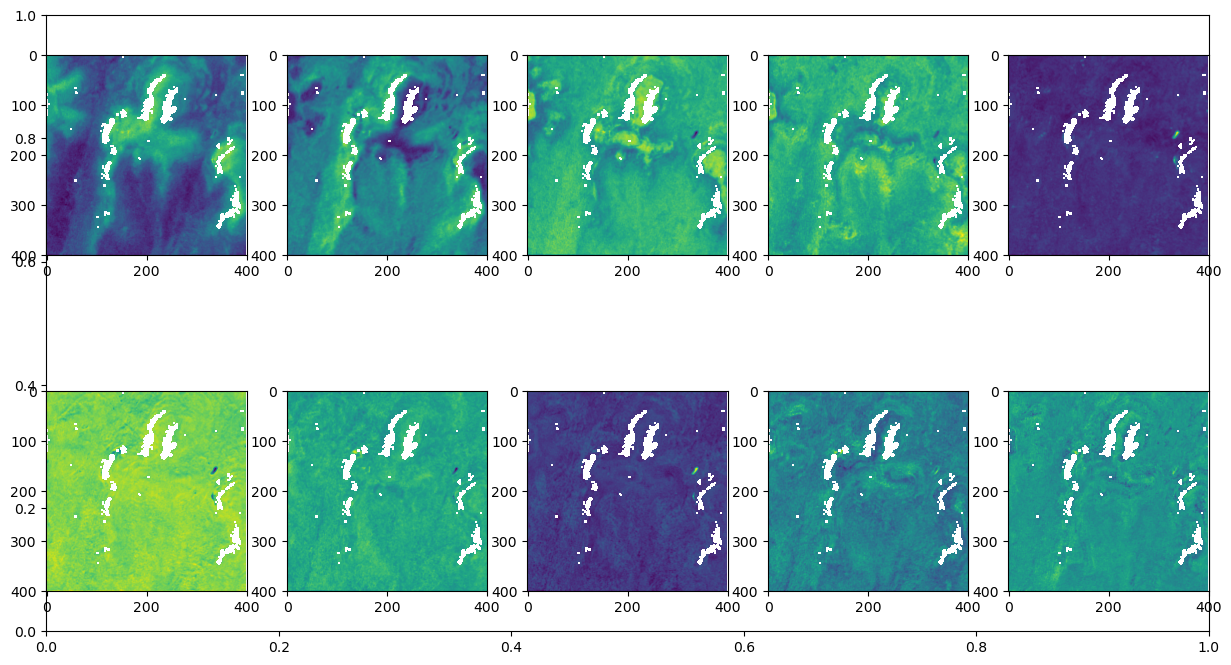

In [45]:
w.plot_mnf(rows=2,cols=5,n_components=10)

In [42]:
class MNF():
    def __init__(self,input_data):
        self.data = input_data.values
        self.mnf = None

    def make_2d_input_data(self):
        x_2d = rearrange(self.data,'h w c -> (h w) c')
        x_dropna = x_2d[~np.isnan(x_2d).any(axis=1)]  # Remove rows with NaNs
        
        # get indices of dropped nas to replace them later
        na_indices = np.where(np.isnan(x_2d))
        row_indices = np.unique(na_indices[0]) # indices of rows that were dropped from a_2d

        return x_2d, x_dropna, row_indices


    # creates noise covariance matrix given 3d input data 
    def noise_from_diffs(self, direction='lowerright'):
        '''Estimates noise statistcs by taking differences of adjacent pixels.'''
        X = self.data
        if direction.lower() not in ['lowerright', 'lowerleft', 'right', 'lower']:
            raise ValueError('Invalid `direction` value.')
        if direction == 'lowerright':
            deltas = X[:-1, :-1, :] - X[1:, 1:, :]
        elif direction == 'lowerleft':
            deltas = X[:-1, 1:, :] - X[1:, :-1, :]
        elif direction == 'right':
            deltas = X[:, :-1, :] - X[:, 1:, :]
        else:
            deltas = X[:-1, :, :] - X[1:, :, :]
        
        deltas_2d = rearrange(deltas, 'h w c -> (h w) c')
        # remove nans
        deltas_dropna = deltas_2d[~np.isnan(deltas_2d).any(axis=1)]  # Remove rows with NaNs
    
        cov = np.cov(deltas_dropna,rowvar=False)
        cov /= 2.0
        return cov

    # calculate sqrt of inverse covariance matrix of noise matrix
    def get_sqrt_inv_cov(self,x):  
        (vals, V) = np.linalg.eig(x)
        SRV = np.diag(1. / np.sqrt(vals))
        return V @ SRV @ V.T
    
    def make_mnf(self):
        if self.mnf is not None:
            print('self.mnf already exists')
        else:
            ######### define terms ###########
            X_2d, X_dropna, na_rows = self.make_2d_input_data()
            # covariance matrix of input data
            signal_cov = np.cov(X_dropna,rowvar=False)

            # mean of input data
            m = np.average(X_dropna, axis=0)

            # noise covariance matrix
            noise_cov = self.noise_from_diffs()
            # square root inverse covariance noise matrix
            noise_sqrt_inv_cov = self.get_sqrt_inv_cov(noise_cov)


            ######## create minimum noise fraction image ##########

            # whitens signal cov using noise cov; use sqrt to scale
            C = noise_sqrt_inv_cov @ signal_cov @ noise_sqrt_inv_cov

            #get eigenvectors of whitened signal covariance matrix
            (L, V) = np.linalg.eig(C)  # L = eigenvalues, V = eigenvectors      
            # sort the eigenvectors
            if not np.all(np.diff(L) <= 0):
                ii = list(reversed(np.argsort(L)))
                L = L[ii]
                V = V[:, ii]

            N = 10 # retain NAPC components where SNR >= 10.
            A = V[:, :N].T @ noise_sqrt_inv_cov  

            X = X_dropna - m    # mean correction of input data

            Y = (A @ X.T).T   # pca rotation (noise-adjusted pca)

            # replace nans that were dropped earlier
            output_array = np.full((X_2d.shape[0],Y.shape[1]), np.nan)  # create array of correct shape

            # Fill in the rows that were not NaN
            non_nan_indices = np.setdiff1d(np.arange(X_2d.shape[0]), na_rows)  # get indices that don't have na values
            output_array[non_nan_indices] = Y

            mnf = rearrange(output_array, '(h w) c -> h w c', h=self.data.shape[0], w=self.data.shape[1])
            print(f'mnf image of shape {mnf.shape}')
            self.mnf = mnf
        
    def plot_mnf(self,rows, cols, n_components):
        if self.mnf is None:
            print('need to run make_mnf()')
        else:

            fig = plt.subplots(figsize=(15,8))

            for i in range(0,n_components):
                plt.subplot(rows, cols, i+1)
                plt.imshow(self.mnf[:,:,i])

            plt.show()

    


### Select endmember pixels

In [85]:
polys = gpd.read_file(root / 'beech_stands' / 'Beech Stand Polygons.kml')
r = Endmembers(26918,w.mnf,polys)

C:\Users\roseh\AppData\Local\Temp\ipykernel_18344\3370979472.py:8: RuntimeWarning: All-NaN axis encountered
  np.nanmax(g.index)


np.float64(nan)

In [84]:

class Endmembers():
    def __init__(self,epsg,mnf_data,beech_polygons):
        a = xr.DataArray(mnf_data, coords={'y': stack.all_variables.y,'x': stack.all_variables.x,'band':np.arange(0,w.mnf.shape[2])}, 
                    dims=['y','x','band'])
        self.epsg = epsg
        self.mnf = a.rio.write_crs(self.epsg).rio.set_spatial_dims(x_dim="x",y_dim="y",).rio.write_coordinate_system()
        self.polygons = beech_polygons.reset_index().to_crs(self.epsg)
        self.bbox = self.get_bbox()

        self.site_polygons = self.get_site_polygons() # polygons that intersect with bbox

        self.beech_idx = self.site_polygons.loc[self.site_polygons.Name!='non-beech stand']['index'].astype('float').values
        
        self.raster_polys = self.rasterize_polys()

        self.beech_pixels = None

    def get_bbox(self):
        b = self.mnf.rio.bounds()
        return box(*b)
    
    def get_site_polygons(self):
        df = gpd.GeoDataFrame({"id":1,"geometry":[self.bbox]})
        idx = df.sindex.query(self.polygons.geometry, predicate="intersects")[0]
        return self.polygons.iloc[idx]
    
    # rasterize polygons
    def rasterize_polys(self):
        g = make_geocube(
        vector_data=self.site_polygons,
        measurements=["index"],
        like=self.mnf, # ensure the data are on the same grid
    )
        return g
    
    # plot rasterized polygons overlaid with vector polygons
    def plot_rasterized_polys(self):
        fig, ax = plt.subplots(ncols=1, figsize=(5, 5))

        p = self.raster_polys.index.plot.imshow(ax=ax)
        self.site_polygons.plot(ax=ax,alpha=.7)
        p.colorbar.remove()
        plt.title(f'Rasterized Beech Polygons')
        plt.tight_layout()
        plt.show()

    # store pixel values for each plot in dataframe
    def extract_beech_pixels(self):
        
        id = self.beech_idx
       
        if len(id) == 1:
            pixels = self.mnf.where(self.raster_polys.index==float(id[0])).assign_coords({'band':self.mnf.band.values})
        else:
            pixels = self.mnf.where((self.raster_polys.index==float(id[0]))|(self.raster_polys.index==int(id[1])))

        self.beech_pixels = pixels

In [ ]:
import geopandas as gpd

def read_catskills_points(root,file):

    pts = gpd.read_file(root / 'beech_stands' / file )
    pts = pts.to_crs(26918)
    # remove first 4 rows
    pts2 = pts.loc[4:,]

    # make separate species and dbh columns
    pts2['species'] = [x[0] for x in pts2.Name.str.split('dbh')]
    pts2['dbh'] = [x[-1] for x in pts2.Name.str.split('dbh')]
    pts2 = pts2.drop('Name',axis=1)

    # make separate beech and nonbeech gdf
    pts2['species'] = pts2.species.str.strip()
    beech_pts = pts2.loc[pts2.species=='beech']
    beech_pts.shape
    beech_pts['index'] = np.arange(0,len(beech_pts))

    nonbeech_pts = pts2.loc[pts2.species!='beech']
    nonbeech_pts.shape
    nonbeech_pts = nonbeech_pts.reset_index()

    return beech_pts, nonbeech_pts

beech_pts, nonbeech_pts = read_catskills_points(root,'Points.shp')

In [58]:
p = xr.open_dataset(root / 'output' / 'BART' / 'percent_basal_area_BART.nc')['percent_beech_basal_area']
# get pixes with % basal area greater than some number
h = p.where(p > 0.0035)
h = h.values

rows, cols = np.where(~np.isnan(h))

pixels = [(int(row),int(col)) for row,col in zip(rows,cols)]
len(pixels)

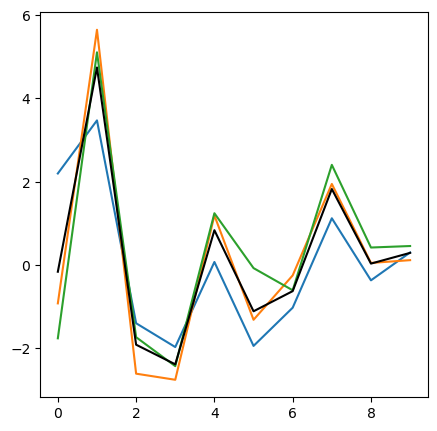

In [66]:
#h.shape = (y,x), mnf.shape = (y,x,b), y=rows(height), x=columns(width), 
p_list = []

for i in range(0,len(pixels)):
    p_list.append(mnf[pixels[i][0],pixels[i][1],:])

p_m = np.array(p_list) # exclude first pixel bc it looked wierd

p_mean = np.mean(p_m,axis=0)

fig,ax = plt.subplots(figsize=(5,5))

for i in range(0,p_m.shape[0]):
    plt.plot(p_m[i])

plt.plot(p_mean,color='black')

plt.show()

### MTMF

In [ ]:
# code based on spectral package
# y={(mu_t-mu_b)^TSigma^{-1}(x-mu_b)}/{(mu_t-mu_b)^TSigma^{-1}(mu_t-mu_b)}

def replace_na_and_reshape(data_2d,data_3d,final_data,indices):
    # replace nans that were dropped earlier
    output = np.full((data_2d.shape[0]), np.nan)  # create array of correct shape

    # Fill in the rows that were not NaN
    non_nan_indices = np.setdiff1d(np.arange(data_2d.shape[0]), indices)  # get indices that don't have na values
    output[non_nan_indices] = final_data

    shape= data_3d.shape
    r = output_array.reshape((shape[0],shape[1]) + (-1,)).squeeze()

    # create data array with geographic coordinates
    return xr.DataArray(r, coords={'y': s.y, 'x': s.x},dims=['y','x'])

In [ ]:
# Target spectral signature 
target = p_mean
# background mean 
u_b = np.nanmean(mnf, axis=(0, 1))  
# difference between target and background mean
d_tb = (target- u_b)

# Calculate the covariance matrix of the background
# reshape mnf data from 3d to 2d
mnf_2d, mnf_dropna, na_indices = make_2d_input_data(mnf) 
C = np.cov(mnf_dropna, rowvar=False)  # Covariance matrix
# Calculate the inverse of the covariance matrix
C1 = np.linalg.inv(C)

 # Normalization coefficient (inverse of  squared Mahalanobis distance
# between u_t and u_b)
coef = 1.0 / d_tb @ C1 @ d_tb

# 2d array input
X = mnf_dropna
A = (coef * d_tb) @ C1 #transform method 
Y = (A @ X.T).T

out = replace_na_and_reshape(data_2d=mnf_2d,data_3d=mnf,final_data=Y,indices=na_indices)

In [92]:
out.to_netcdf(root / 'output' / 'BART' / 'bartlett_mtmf_withnewmnfinput.nc')

In [ ]:
np.outer(out,p_mean).shape

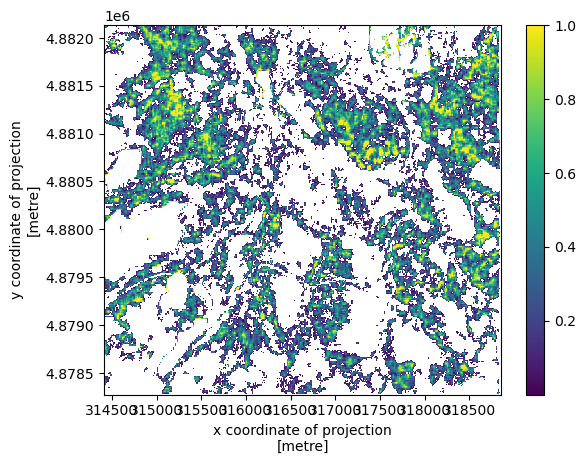

In [102]:
# all values less than 0 set to 0, values greater than 1 set to 1
# t1 = out.where((out<1),1)
# t2 = t1.where((out>0),np.nan)
t2.plot()
t2.to_netcdf(root / 'output' / 'BART' / 'bartlett_mtmf_new_clamped0to1.nc')

# t = out.where((out>0),np.nan)
# t.plot()
# t.to_netcdf(root / 'output' / 'BART' / 'bartlett_mtmf_new_greaterthan0.nc')

In [ ]:
ba = xr.open_dataset(root / 'output' / 'BART' / 'percent_basal_area_BART.nc')
ba = ba['percent_beech_basal_area']

In [95]:
ba_2d = rearrange(ba.to_numpy(),'h w -> (h w)')
t2_2d = rearrange(out.to_numpy(),'h w -> (h w)')

combine = np.vstack((ba_2d,t2_2d)).T

df_dropna = combine[~np.isnan(combine).any(axis=1)]

In [97]:
np.corrcoef(df_dropna,rowvar=False)

array([[1.        , 0.38917399],
       [0.38917399, 1.        ]])

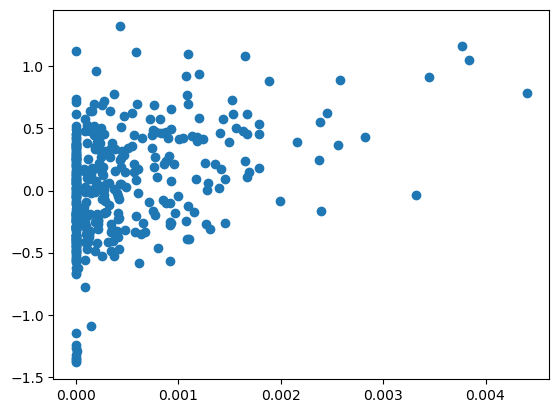

In [96]:
plt.scatter(df_dropna[:,0],df_dropna[:,1])

In [ ]:
# Precompute reusable terms
#mu_diff = mu_t - mu_b  # Difference between target and background mean
# numerator_constant = mu_diff.T @ Sigma_inv  # Precompute (mu_t - mu_b)^T Sigma^-1
# denominator = mu_diff.T @ Sigma_inv @ mu_diff  # Precompute denominator

# Initialize output array for matched filtering scores
#mf_scores = np.zeros((reshaped_data.shape[0], reshaped_data.shape[1]))


# Vectorized implementation
x_diff = reshaped_data - u_b  # Subtract background mean from all pixels (pixels x bands)
numerator = x_diff @ C1 @ d_tb  # Compute the numerator for all pixels
denominator = d_tb.T @ C1 @ d_tb  # Precompute denominator
mf_scores_vectorized = numerator.reshape(reshaped_data.shape[0], reshaped_data.shape[1]) / denominator  # Reshape to image dimensions

In [ ]:

# mtmf code based on spectral package



def cov(M):
    """
    Compute the sample covariance matrix of a 2D matrix.

    Parameters:
      M: `numpy array`
        2d matrix of HSI data (N x p)

    Returns: `numpy array`
        sample covariance matrix
    """
    N = M.shape[0]
    u = M.mean(axis=0)
    M = M - np.kron(np.ones((N, 1)), u)
    C = np.dot(M.T, M) / (N-1)
    return C



def whiten(M):
    """
    Whitens a HSI cube. Use the noise covariance matrix to decorrelate
    and rescale the noise in the data (noise whitening).
    Results in transformed data in which the noise has unit variance
    and no band-to-band correlations.

    Parameters:
        M: `numpy array`
            2d matrix of HSI data (N x p).

    Returns: `numpy array`
        Whitened HSI data (N x p).

    Reference:
        Krizhevsky, Alex, Learning Multiple Layers of Features from
        Tiny Images, MSc thesis, University of Toronto, 2009.
        See Appendix A.
    """
    sigma = util.cov(M)
    U,S,V = np.linalg.svd(sigma)
    S_1_2 = S**(-0.5)
    S = np.diag(S_1_2.T)
    Aw = np.dot(V, np.dot(S, V.T))
    return np.dot(M, Aw)


class Whiten(object):
    """Whiten the cube."""

    def __init__(self):
        self.dM = None

    @ApplyInputValidation('Whiten')
    def apply(self, M):
        """
        Whitens a HSI cube. Use the noise covariance matrix to decorrelate
        and rescale the noise in the data (noise whitening).
        Results in transformed data in which the noise has unit variance
        and no band-to-band correlations.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A whitened HSI cube (m x n x p).
        """
        h, w, numBands = M.shape
        M = np.reshape(M, (w*h, numBands))
        dM = dnoise.whiten(M)
        self.dM = np.reshape(dM, (h, w, numBands))
        return self.dM

    def get(self):
        """
        Returns: `numpy array`
            The whitened HSI cube (m x n x p).
        """
        return self.dM


class MNF(object):
    """Transform a HSI cube."""

    def __init__(self):
        self.mnf = None
        self.transform = None
        self.wdata = None # temp

    @ApplyInputValidation('MNF')
    def apply(self, M):
        """
        A linear transformation that consists of a noise whitening step
        and one PCA rotation.

        This process is designed to
            * determine the inherent dimensionality of image data,
            * segregate noise in the data,
            * allow efficient elimination and/or reduction of noise, and
            * reduce the computational requirements for subsequent processing.

        Parameters:
            M: `numpy array`
              A HSI cube (m x n x p).

        Returns: `numpy array`
              A MNF transformed cube (m x n x p).

        References:
          C-I Change and Q Du, "Interference and Noise-Adjusted Principal
          Components Analysis," IEEE TGRS, Vol 36, No 5, September 1999.
        """
        from sklearn.decomposition import PCA
        w = Whiten()
        wdata = w.apply(M)
        self.wdata = wdata #temp
        h, w, numBands = wdata.shape
        X = np.reshape(wdata, (w*h, numBands))
        self.transform = PCA()
        mnf = self.transform.fit_transform(X)
        self.mnf = np.reshape(mnf, (h, w, numBands))
        return self.mnf